In [0]:
#Linea de Espacio

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/CS221/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!ls
#df_SF1.to_csv (r'gdrive/My Drive/Colab Notebooks/CS230_PROJECT/AMZN_SF1.csv', index = True, header=True) # Path Example

gdrive	sample_data


In [3]:
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y

# Special gym environment
#!pip3 install box2d-py==2.3.8
!apt-get install python-box2d
!pip3 install box2d-py==2.3.8
#!pip install box2d-py
#!pip install gym[Box_2D]

#!pip install gym[LunarLander-v2]

# For rendering environment, you can use pyvirtualdisplay.
!pip install pyvirtualdisplay
!pip install piglet

# To activate virtual display 
# need to run a script once for training an agent as follows
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

#
# Import libraries
#
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env


Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.4).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-box2d is already the newest version (2.3.2~dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [5]:
!pip install ptan

     |████████████████████████████████| 773.1MB 22kB/s 
  Created wheel for ptan: filename=ptan-0.6-cp36-none-any.whl size=23502 sha256=e4e95f4d66523444f8d9014d2aaa5545919e2cdc1166ffc329b6b1d5f0801fce
  Stored in directory: /root/.cache/pip/wheels/f0/4b/2f/9a45fd39b0a614a2716bc6128a7f1adb4647f323a2d90783f2
Successfully built ptan
ERROR: torchvision 0.6.0+cu101 has requirement torch==1.5.0, but you'll have torch 1.3.0 which is incompatible.
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101


In [0]:
import gym
import ptan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

In [0]:
env = gym.make('LunarLander-v2')
env.reset()
for _ in range(1000):
    #env.render()
    env.step(env.action_space.sample())
    #env.render()
    env.step(env.action_space.sample())
env.close()

In [0]:
class PolicyNetwork(nn.Module):
    """
    PGN-Policy Gradient Network (Function Approximator):
    
    - input size: number of observation states in environment
    - n_actions: number of actions in environment
    
    We will use neural network with one hidden layer, which 
    has one hidden layer with 128 neurons and ReLU activation function, 
    as was described in report. So, our vector of \theta parameters 
    will have 128 elements. 
    
    """
    # initialization function
    def __init__(self, input_size, n_actions):
        super(PolicyNetwork, self).__init__()
        # Creating a simple neural network with 128 parameters \theta
        # in one hidden layer 
        # Softmax activation will be done in the algorithm later.
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )
    
    # forward propagation function
    def forward(self, x):
        return self.net(x)

In [0]:
def compute_q_vals(rewards):
    """
    rewards: list of rewards collected in episode
    """
    res = []
    sum_r = 0.0
    # looping through the list of rewards in reverse order
    # because in REINFORCE (look at report pseudocode)
    # last action receives one last reward, pre-last action
    # receives pre-last reward plus discounted last etc.:
    for r in reversed(rewards):
        sum_r *= 0.99 #GAMMA
        sum_r += r
        res.append(sum_r)
    # we againg reverse our list of rewards per action
    # in the order actions appeared
    return list(reversed(res))

In [0]:

def REINFORCE(learning_rate, gamma=0.99, num_episodes_train=4, env="LunarLander-v2", max_num_steps=35000000):
    """
    -learning rate:     coefficient, by which we multiply gradient in update rule
    
    -gamma:             discount coefficient from bellmann equation
    
    -num_episode_train: number of episodes in which we collect experience 
                        before performing learning
    
    -env:               environment used in training.
    
    -max_num_steps:     num of steps after which training established unsuccessful
    """
    
    #creating separate list for indexes of steps taken
    step_list = [] 
    #creating separate list for mean rewards of last 100 episodes
    mean_rewards_list = []
    #values of gradient vactor variance
    var_grad_list = []

    #creating an instance of 'LunarLander' environment using Gym library
    env = gym.make(env)   
    #creating an instance of above defined Policy Gradient Network
    #our input 
    net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
    # creating an artificial agent using library ptan, which under the hood
    # get network raw results and applies softmax activation to choose action
    # from the state
    agent = ptan.agent.PolicyAgent(net, preprocessor=ptan.agent.float32_preprocessor,
                                               apply_softmax=True)
    # create experience source with LunarLander environment
    exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=gamma)
    # we will use Adam optimizer as it is considered the only option
    # which really works in RL setting
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    #create list for collecting total rewards
    total_rewards = []
    
    # creating counters
    step_idx = 0
    done_episodes = 0
    batch_episodes = 0
    
    # creating empty list, where we will store batches of 
    # states, actions, q-values to use it in our policy 
    # gradient algo
    batch_states, batch_actions, batch_qvals = [], [], []
    cur_rewards = []
    # iterate over each step in environment until 
    # last episode in batch of episodes used for training 
    # is finished
    for step_idx, exp in enumerate(exp_source):
        batch_states.append(exp.state)
        batch_actions.append(int(exp.action))
        cur_rewards.append(exp.reward)
        # check whether episde
        if exp.last_state is None:
            batch_qvals.extend(compute_q_vals(cur_rewards))
            cur_rewards.clear()
            batch_episodes += 1

        new_rewards = exp_source.pop_total_rewards()
        
        # check whether episode ended
        # if episode ends then we will append all rewards to 
        # our total rewards list
        if new_rewards:
            done_episodes += 1
            reward = new_rewards[0]
            total_rewards.append(reward)
            
            # calculate mean reward per last 100 steps;
            # episode can contain more but we assume
            # that environment is solved if mean reward 
            # per 100 steps > 195
            mean_rewards = float(np.mean(total_rewards[-100:]))
            
            # monitor how our agent is learning 
            print("%d: reward: %6.2f, mean_100: %6.2f, episodes: %d" % (
                step_idx, reward, mean_rewards, done_episodes))
            
            # collecting steps, mean rewards and rewards_list in order
            # to use afterwards in comparing our algorithms
            step_list.append(step_idx)
            mean_rewards_list.append(mean_rewards)
            
            # check whether our environment is solved 
            if mean_rewards > 195:
                print("Solved in %d steps and %d episodes!" % (step_idx, done_episodes))
                break
                
            # establish some reasonable point of time
            # where there is no need to destroy our CPU
            elif step_idx > max_num_steps:
                print(0.01,':not_converged')
                print('')
                break
        # check whether we iterated over necessary
        # number of episode;
        
        # if not - continue to collect experience
        if batch_episodes < num_episodes_train:
            continue
        
        # setting the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # converting our lists to float tensors
        states_v = torch.FloatTensor(batch_states)
        batch_actions_t = torch.LongTensor(batch_actions)
        batch_qvals_v = torch.FloatTensor(batch_qvals)
        
        # doing forward propagation via our 128 randomly inialized weights
        logits_v = net(states_v)
        
        # outputting probabilities per each action
        log_prob_v = F.log_softmax(logits_v, dim=1)
        
        # multiplying our q-values with log probability 
        log_prob_actions_v = batch_qvals_v * log_prob_v[range(len(batch_states)), batch_actions_t]
        
        # averaging out our loss
        loss_v = -log_prob_actions_v.mean()
        
        #finding gradient of the loss
        loss_v.backward()
        
        #performing update rule 
        optimizer.step()
        
        
        grads = np.concatenate([p.grad.data.cpu().numpy().flatten()
                                            for p in net.parameters()
                                            if p.grad is not None])

        var_grad_list.append(np.var(grads))
        
        #clearing out all accumulated experience before doing new iteration
        batch_episodes = 0
        batch_states.clear()
        batch_actions.clear()
        batch_qvals.clear()
        
    return step_list,mean_rewards_list,net

In [10]:
step_list,mean_rewards_list,net = REINFORCE(0.01, gamma=0.99, num_episodes_train=4, env="LunarLander-v2", max_num_steps=2000000)

79: reward: -375.40, mean_100: -375.40, episodes: 1
142: reward: -215.10, mean_100: -295.25, episodes: 2
209: reward: -177.69, mean_100: -256.06, episodes: 3
314: reward: -157.66, mean_100: -231.46, episodes: 4
430: reward: -156.53, mean_100: -216.48, episodes: 5
531: reward: -199.42, mean_100: -213.63, episodes: 6
654: reward: -142.85, mean_100: -203.52, episodes: 7
719: reward: -78.05, mean_100: -187.84, episodes: 8
863: reward: -209.91, mean_100: -190.29, episodes: 9
996: reward: -100.80, mean_100: -181.34, episodes: 10
1080: reward: -335.52, mean_100: -195.36, episodes: 11
1147: reward: -344.67, mean_100: -207.80, episodes: 12
1243: reward: -455.90, mean_100: -226.88, episodes: 13
1366: reward: -78.99, mean_100: -216.32, episodes: 14
1457: reward: -132.17, mean_100: -210.71, episodes: 15
1561: reward: -83.15, mean_100: -202.74, episodes: 16
1779: reward: -226.07, mean_100: -204.11, episodes: 17
1881: reward: -267.36, mean_100: -207.62, episodes: 18
1990: reward: -164.88, mean_100: 

In [0]:
torch.save(net.state_dict(), 'gdrive/My Drive/Colab Notebooks/CS221/lunar_lander_model.pt')

In [0]:
df = pd.DataFrame()
df['mean_reward_100_steps'] = mean_rewards_list
df['steps'] = step_list
df.to_csv('gdrive/My Drive/Colab Notebooks/CS221/reinforce_0.01.csv')

In [13]:
# learn rate 0.001
step_list_001,mean_rewards_list_001,net_001 = REINFORCE(0.001, gamma=0.99, num_episodes_train=4, env="LunarLander-v2", max_num_steps=2000000)
df = pd.DataFrame()
# save results
df['mean_reward_100_steps'] = mean_rewards_list_001
df['steps'] = step_list_001
df.to_csv('gdrive/My Drive/Colab Notebooks/CS221/reinforce_0.001.csv')


Streaming output truncated to the last 5000 lines.
116243: reward: -96.82, mean_100: -107.34, episodes: 1283
116340: reward: -94.40, mean_100: -107.37, episodes: 1284
116404: reward: -44.18, mean_100: -106.77, episodes: 1285
116524: reward: -196.84, mean_100: -107.43, episodes: 1286
116583: reward: -59.45, mean_100: -107.09, episodes: 1287
116716: reward: -167.75, mean_100: -107.97, episodes: 1288
116840: reward: -72.05, mean_100: -107.29, episodes: 1289
116908: reward: -89.25, mean_100: -107.15, episodes: 1290
116973: reward: -53.68, mean_100: -106.61, episodes: 1291
117074: reward: -81.67, mean_100: -105.04, episodes: 1292
117174: reward: -109.06, mean_100: -104.29, episodes: 1293
117291: reward: -116.53, mean_100: -104.30, episodes: 1294
117350: reward: -86.41, mean_100: -104.00, episodes: 1295
117465: reward: -88.45, mean_100: -103.30, episodes: 1296
117559: reward: -96.95, mean_100: -103.23, episodes: 1297
117626: reward: -68.42, mean_100: -102.61, episodes: 1298
117732: reward: -

In [14]:
# learn rate 0.1
step_list_1,mean_rewards_list_1,net_001 = REINFORCE(0.1, gamma=0.99, num_episodes_train=4, env="LunarLander-v2", max_num_steps=3000000)
df = pd.DataFrame()
# save results
df['mean_reward_100_steps'] = mean_rewards_list_1
df['steps'] = step_list_1
df.to_csv('gdrive/My Drive/Colab Notebooks/CS221/reinforce_0.1.csv')

Streaming output truncated to the last 5000 lines.
2664200: reward: -466.72, mean_100: -574.41, episodes: 39636
2664259: reward: -539.37, mean_100: -575.94, episodes: 39637
2664315: reward: -494.47, mean_100: -572.52, episodes: 39638
2664368: reward: -469.87, mean_100: -571.86, episodes: 39639
2664423: reward: -451.74, mean_100: -570.00, episodes: 39640
2664473: reward: -384.56, mean_100: -569.28, episodes: 39641
2664557: reward: -554.10, mean_100: -569.68, episodes: 39642
2664685: reward: -633.12, mean_100: -571.45, episodes: 39643
2664752: reward: -580.16, mean_100: -572.19, episodes: 39644
2664828: reward: -769.50, mean_100: -575.36, episodes: 39645
2664892: reward: -524.38, mean_100: -576.00, episodes: 39646
2664969: reward: -616.53, mean_100: -571.60, episodes: 39647
2665021: reward: -446.57, mean_100: -570.02, episodes: 39648
2665094: reward: -636.86, mean_100: -570.86, episodes: 39649
2665180: reward: -1005.99, mean_100: -575.15, episodes: 39650
2665272: reward: -1121.77, mean_1

In [0]:
reinf_v1 = pd.read_csv('gdrive/My Drive/Colab Notebooks/CS221/reinforce_0.01.csv')
reinf_v2 = pd.read_csv('gdrive/My Drive/Colab Notebooks/CS221/reinforce_0.001.csv')
reinf_v3 = pd.read_csv('gdrive/My Drive/Colab Notebooks/CS221/reinforce_0.1.csv')

reinf_v1.drop('Unnamed: 0',axis=1,inplace=True)
reinf_v2.drop('Unnamed: 0',axis=1,inplace=True)
reinf_v3.drop('Unnamed: 0',axis=1,inplace=True)

reinf_v3['mean_0.01'] = reinf_v1['mean_reward_100_steps']
reinf_v3['mean_0.01_steps'] = reinf_v1['steps']
reinf_v3['mean_0.001'] = reinf_v2['mean_reward_100_steps']
reinf_v3['mean_0.001_steps'] = reinf_v2['steps']

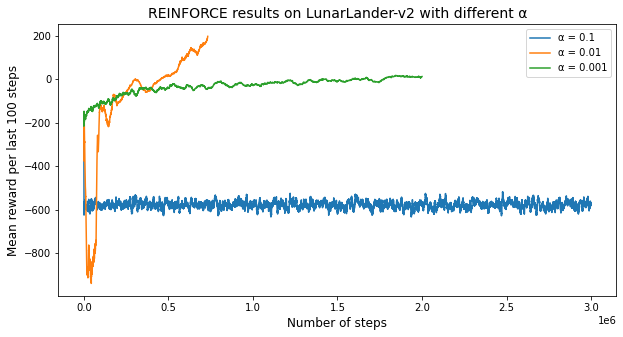

In [16]:
plt.figure(figsize=(10,5))
plt.plot(reinf_v3['steps'],reinf_v3['mean_reward_100_steps'])
plt.plot(reinf_v3['mean_0.01_steps'],reinf_v3['mean_0.01'])
plt.plot(reinf_v3['mean_0.001_steps'],reinf_v3['mean_0.001'])


plt.xlabel('Number of steps',fontSize=12)
plt.ylabel('Mean reward per last 100 steps',fontSize=12)

plt.legend(['α = 0.1','α = 0.01','α = 0.001'])
plt.title('REINFORCE results on LunarLander-v2 with different α',fontSize=14)
plt.show()

In [0]:
class A2C(nn.Module):
    """
    A2C-Advantage Actor Critic (has two function approximators):
    
    - input size: number of observation states in environment
    - n_actions: number of actions in environment
    
    We will use neural network with one hidden layer, which 
    has one hidden layer with 128 neurons and ReLU activation function, 
    as was described in report. So, our vector of \theta parameters 
    will have 128 elements. 
    
    """
    # initialization function
    def __init__(self, input_size, n_actions):
        super(A2C, self).__init__()
        # Creating a simple neural network with 128 parameters \theta
        # in one hidden layer 
        # Softmax activation will be done in the algorithm later.
        self.policy = nn.Sequential(nn.Linear(input_size, 128),nn.ReLU(),nn.Linear(128, n_actions))
        # Creating a simple neural network with 128 parameters \w
        # in one hidden layer 
        self.value = nn.Sequential(nn.Linear(input_size, 128),nn.ReLU(),nn.Linear(128, 1))
    # forward propagation function
    def forward(self, x):
        return self.policy(x), self.value(x)

In [0]:
def batch_transform(batch, net, device='cpu'):
    """
    Transforming batch of data into training tensors
    batch: (states, actions, rewards)
    return: states variable, actions tensor, reference values variable
    """
    REWARD_STEPS=1000
    #create empty lists
    states = []
    actions = []
    rewards = []
    #list for index
    not_done_idx = []
    last_states = []
    #loop over every experience step in a batch
    for idx, exp in enumerate(batch):
        #save triples (s,v,a)
        states.append(np.array(exp.state, copy=False))
        actions.append(int(exp.action))
        rewards.append(exp.reward)
        #check whether las state is given
        if exp.last_state is not None:
            not_done_idx.append(idx)
            last_states.append(np.array(exp.last_state, copy=False))
    #convering to FloatTensor
    states_v = torch.FloatTensor(states).to(device)
    actions_t = torch.LongTensor(actions).to(device)
    # handle rewards
    rewards_np = np.array(rewards, dtype=np.float32)
    #if episode are not done apply network and collect rewards:
    if not_done_idx:
        last_states_v = torch.FloatTensor(last_states).to(device)
        last_vals_v = net(last_states_v)[1]
        last_vals_np = last_vals_v.data.cpu().numpy()[:, 0]
        rewards_np[not_done_idx] += GAMMA ** REWARD_STEPS * last_vals_np
    # 
    ref_vals_v = torch.FloatTensor(rewards_np).to(device)
    return states_v, actions_t, ref_vals_v

In [19]:
!pip install tensorboardX

     |████████████████████████████████| 204kB 2.7MB/s 


In [0]:
# import SummaryWriter to save results
#%load_ext tensorboard
from tensorboardX import SummaryWriter

GAMMA = 0.99
LEARNING_RATE = 0.005
ENTROPY_BETA = 0.01
BATCH_SIZE = 128
#will be doing some gradient clipping so as gradient wouldn't explode
CLIP_GRAD = 0.1


#we use CPU
device = torch.device('cpu')
#writing to tensorboardX
writer = SummaryWriter(comment="-lander-a2c_")
# creating function to iterate via environments
make_env = lambda: gym.make("LunarLander-v2")

#creating list of environments to train with
#envs = [make_env() for _ in range(50)]
envs = [make_env() for _ in range(10)]

#creating actor critic net
net = A2C(envs[0].observation_space.shape[0], envs[0].action_space.n).to(device)
print(net)

# creating agent with experience sourse as in REINFORCE that will
# run 10 steps in a row as in REINFORCE
agent = ptan.agent.PolicyAgent(lambda x: net(x)[0], apply_softmax=True, device=device)
exp_source = ptan.experience.ExperienceSourceFirstLast(envs, agent, gamma=GAMMA, steps_count=10)

#creating Adam agent
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, eps=1e-3)

batch = []
done_episodes = 0
step_idx = 0
total_rewards = []
    
#iterate of each step of environment until the last batch    
for step_idx, exp in enumerate(exp_source):
    batch.append(exp)
    
    new_rewards = exp_source.pop_total_rewards()
    #check whether episode ended since pop_total_rewards() outputs value only
    #in this case
    if new_rewards:
        done_episodes += 1
        reward = new_rewards[0]
        total_rewards.append(reward)
        # calculate mean reward per last 100 steps;
            # episode can contain more but we assume
            # that environment is solved if mean reward 
            # per 100 steps > 195
        mean_rewards = float(np.mean(total_rewards[-100:]))
        #writing to tensorboardX
        writer.add_scalar("reward_100", mean_rewards, step_idx)
        #check whether it is solved:
        if mean_rewards > 195:
            print("Solved in %d steps and %d episodes!" % (step_idx, done_episodes))
            break
        
        
    #we will use batch of size 128 for one iteration
    if len(batch) < 128:
        continue
    
    
    states_v, actions_t, vals_ref_v = batch_transform(batch, net, device=device)
    batch.clear()
    # setting the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes
    optimizer.zero_grad()
    #performing forward propagation
    logits_v, value_v = net(states_v)
    loss_value_v = F.mse_loss(value_v.squeeze(-1), vals_ref_v)
    # finding probabilities for actions 
    log_prob_v = F.log_softmax(logits_v, dim=1)
    # this is our Advantage value
    adv_v = vals_ref_v - value_v.detach()
    log_prob_actions_v = adv_v * log_prob_v[range(BATCH_SIZE), actions_t]
    loss_policy_v = -log_prob_actions_v.mean()
    #calculating probabilities in order to calculate our entropy loss for 
    prob_v = F.softmax(logits_v, dim=1)
    entropy_loss_v = ENTROPY_BETA * (prob_v * log_prob_v).sum(dim=1).mean()

    # calculate policy gradients only
    loss_policy_v.backward(retain_graph=True)
    grads = np.concatenate([p.grad.data.cpu().numpy().flatten()
                                        for p in net.parameters()
                                        if p.grad is not None])

    # apply entropy and value gradients
    loss_v = entropy_loss_v + loss_value_v
    #doing backprop
    loss_v.backward()
    #performing gradient clipping so that there is no gradient explosion
    #nn_utils.clip_grad_norm_(net.parameters(), CLIP_GRAD)
    #update values of network parametes
    optimizer.step()
                # get full loss
    loss_v += loss_policy_v
writer.close()

A2C(
  (policy): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
  (value): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [0]:
df_a2c = pd.read_csv('gdrive/My Drive/Colab Notebooks/CS221/lander-a2c-tag-reward_100.csv')

In [0]:
reinf_v3['mean_a2c'] = df_a2c['Value']
reinf_v3['steps_a2c'] = df_a2c['Step']

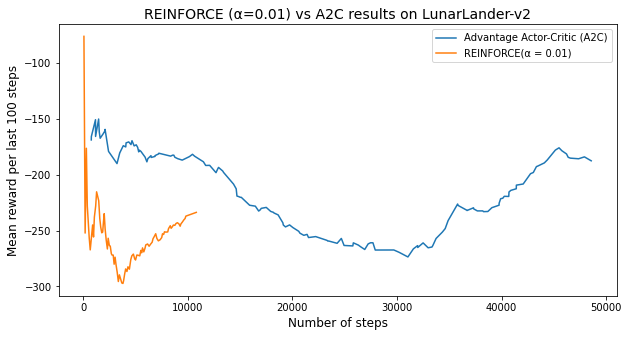

In [0]:
plt.figure(figsize=(10,5))
plt.plot(reinf_v3['steps_a2c'],reinf_v3['mean_a2c'])
plt.plot(reinf_v3['mean_0.01_steps'],reinf_v3['mean_0.01'])

plt.xlabel('Number of steps',fontSize=12)
plt.ylabel('Mean reward per last 100 steps',fontSize=12)

plt.legend(['Advantage Actor-Critic (A2C)','REINFORCE(α = 0.01)'])
plt.title('REINFORCE (α=0.01) vs A2C results on LunarLander-v2',fontSize=14)
plt.show()